<a href="https://colab.research.google.com/github/niruthikka24/DataStorm-3.0/blob/main/DataStorm_3_0_NoteBook_3_27_03_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install skforecast

     |████████████████████████████████| 87 kB 6.7 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 56.3 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
# from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv


In [ ]:
df = pd.read_csv('train_data.csv')
df.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [ ]:
Q1 = df['DailySales'].quantile(0.25)
Q3 = df['DailySales'].quantile(0.75)
IQR = Q3 - Q1
whisker_width = 1.5
lower_whisker = Q1 -(whisker_width*IQR)
upper_whisker = Q3 + (whisker_width*IQR)
df['DailySales']=np.where(df['DailySales']>upper_whisker,upper_whisker,np.where(df['DailySales']<lower_whisker,lower_whisker,df['DailySales']))

In [ ]:
df['DateID'] = pd.to_datetime(df['DateID'])
# encoder = OrdinalEncoder()
scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
df["Category"] = df["CategoryCode"].replace(scale_mapper)
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category
0,category_2,117610,2021-11-06,7.0,2
1,category_4,836584,2021-11-18,14.5,4
2,category_1,370195,2022-01-24,6.0,1
3,category_2,172582,2021-10-30,5.0,2
4,category_2,1006009,2021-10-30,5.0,2


In [ ]:
df['year'] = df.DateID.dt.year
df['month'] = df.DateID.dt.month
df['weekofyear'] = df.DateID.dt.weekofyear
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear
0,category_2,117610,2021-11-06,7.0,2,2021,11,44
1,category_4,836584,2021-11-18,14.5,4,2021,11,46
2,category_1,370195,2022-01-24,6.0,1,2022,1,4
3,category_2,172582,2021-10-30,5.0,2,2021,10,43
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43


In [ ]:
df['WeeklySales']  = df.groupby(['Category','ItemCode','weekofyear'])['DailySales'].transform('sum')
# df['WeeklySalesMean']  = df.groupby(['Category','ItemCode','weekofyear'])['DailySales'].transform('mean')
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear,WeeklySales
0,category_2,117610,2021-11-06,7.0,2,2021,11,44,65.0
1,category_4,836584,2021-11-18,14.5,4,2021,11,46,85.5
2,category_1,370195,2022-01-24,6.0,1,2022,1,4,32.5
3,category_2,172582,2021-10-30,5.0,2,2021,10,43,26.0
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43,13.0


In [ ]:
df.shape

(19921, 9)

In [ ]:
weeks_no=[]
for i in df['weekofyear']:
  w=i%4
  weeks_no.append(w)

d2 = pd.Series(weeks_no,name='week_of_month')
df=pd.concat([df, d2], axis=1)
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Category,year,month,weekofyear,WeeklySales,week_of_month
0,category_2,117610,2021-11-06,7.0,2,2021,11,44,65.0,0
1,category_4,836584,2021-11-18,14.5,4,2021,11,46,85.5,2
2,category_1,370195,2022-01-24,6.0,1,2022,1,4,32.5,0
3,category_2,172582,2021-10-30,5.0,2,2021,10,43,26.0,3
4,category_2,1006009,2021-10-30,5.0,2,2021,10,43,13.0,3


In [ ]:
weekly_avg = df.groupby(['Category','ItemCode','weekofyear'])['DailySales'].mean().reset_index()

In [ ]:
df.drop(['DateID','DailySales','CategoryCode'],axis=1,inplace=True)
df = df.drop_duplicates()
df.shape

(4278, 7)

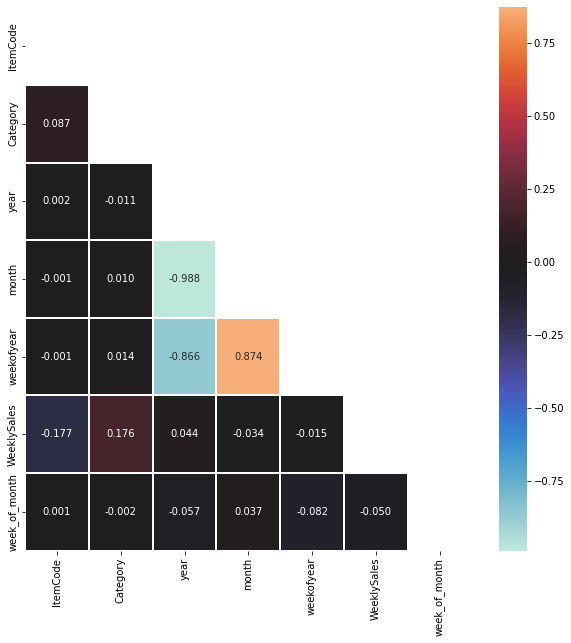

In [ ]:
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".3f", ax = ax)
plt.show()

In [ ]:
#preprocessing the validation and testing data sets
def preprocessDataSet(df):
  scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
  df["Category"] = df["CategoryCode"].replace(scale_mapper)
  scale_mapper1 = {"w1":'2022-02-14', "w2":'2022-02-21', "w3":'2022-02-28',"w4":'2022-03-07'}
  df["DateID"] = df["Week"].replace(scale_mapper1)
  df['DateID'] = pd.to_datetime(df['DateID'])
  df['year'] = df.DateID.dt.year
  df['month'] = df.DateID.dt.month
  df['weekofyear'] = df.DateID.dt.weekofyear
  df.drop(['Week','CategoryCode','DateID'],axis=1,inplace=True)

In [ ]:
valdf = pd.read_csv('validation_data.csv')
valdf.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [ ]:
preprocessDataSet(valdf)
valdf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


,ItemCode,WeeklySales,Category,year,month,weekofyear
0,1044502,11,2,2022,2,7
1,1105009,11,2,2022,2,7
2,913561,5,2,2022,3,10
3,1048975,30,1,2022,3,10
4,17287,60,1,2022,2,8


In [ ]:
weeks_no=[]
for i in valdf['weekofyear']:
  w=i%4
  weeks_no.append(w)

d2 = pd.Series(weeks_no,name='week_of_month')
valdf=pd.concat([valdf, d2], axis=1)
valdf.head()

,ItemCode,WeeklySales,Category,year,month,weekofyear,week_of_month
0,1044502,11,2,2022,2,7,3
1,1105009,11,2,2022,2,7,3
2,913561,5,2,2022,3,10,2
3,1048975,30,1,2022,3,10,2
4,17287,60,1,2022,2,8,0


In [ ]:
trainx = df.drop(['WeeklySales'],axis=1)
trainy = df['WeeklySales']
trainy.head()

0    65.0
1    85.5
2    32.5
3    26.0
4    13.0
Name: WeeklySales, dtype: float64

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


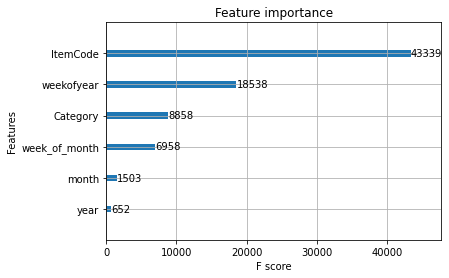

In [ ]:
cmodel = XGBClassifier()
cmodel.fit(trainx, trainy)
# plot feature importance
plot_importance(cmodel)
plt.show()

In [ ]:
model = XGBRegressor()
model.fit(trainx, trainy)

[08:16:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
testx = valdf.drop(['WeeklySales'],axis=1)
testy = valdf["WeeklySales"]

In [ ]:
pred = cmodel.predict(testx)

In [ ]:
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
# LR_MAPE= mape(testy, pred)
# print("MAPE: ",LR_MAPE)

In [ ]:
xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(trainx, trainy)
pred2 = xgb_r.predict(testx)
LR_MAPE= mape(testy, pred2)
print("MAPE: ",LR_MAPE)

[08:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  93.39795531797253


In [ ]:
trainx2 = trainx.drop(['month','year'],axis=1)
print(trainx2.head())
testx2 = testx.drop(['month','year'],axis=1)
print(testx2.head())

   ItemCode  Category  weekofyear  week_of_month
0    117610         2          44              0
1    836584         4          46              2
2    370195         1           4              0
3    172582         2          43              3
4   1006009         2          43              3
   ItemCode  Category  weekofyear  week_of_month
0   1044502         2           7              3
1   1105009         2           7              3
2    913561         2          10              2
3   1048975         1          10              2
4     17287         1           8              0


In [ ]:
cmodel2 = XGBClassifier()
cmodel2.fit(trainx2, trainy)
pred2 = cmodel2.predict(testx2)
LR_MAPE2= mape(testy, pred2)
print("MAPE: ",LR_MAPE2)

MAPE:  65.32280631705105


In [ ]:
rmodel = XGBRegressor()
rmodel.fit(trainx2, trainy)
pred3 = rmodel.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

[14:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  98.85884121712974


In [ ]:
xgb_r = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
xgb_r.fit(trainx2, trainy)
pred3 = xgb_r.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

[14:31:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE:  83.62112050194101


In [ ]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(trainx2,trainy)
rpred = regressor.predict(testx2)
LR_MAPE3= mape(testy, rpred)
print("MAPE: ",LR_MAPE3)

MAPE:  62.05465108430281


In [ ]:
for n in [25,50,75]:
  regressor = RandomForestRegressor(n_estimators = n, random_state = 0)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("n-estimator: ",n)
  print("MAPE: ",LR_MAPE3)

n-estimator:  25
MAPE:  62.93747626140813
n-estimator:  50
MAPE:  62.297596590211576
n-estimator:  75
MAPE:  62.68620425259983


In [ ]:
for n in [5,15,20]:
  regressor = RandomForestRegressor(n_estimators = n, random_state = 0)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("n-estimator: ",n)
  print("MAPE: ",LR_MAPE3)

n-estimator:  5
MAPE:  61.54176766361037
n-estimator:  15
MAPE:  61.24446732523641
n-estimator:  20
MAPE:  61.54937383255825


In [ ]:
for n in [8,12,16]:
  regressor = RandomForestRegressor(n_estimators = n, random_state = 0)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("n-estimator: ",n)
  print("MAPE: ",LR_MAPE3)

n-estimator:  8
MAPE:  61.39379345021372
n-estimator:  12
MAPE:  62.41849562400796
n-estimator:  16
MAPE:  61.29049663617152


In [ ]:
regressor.get_params()

In [ ]:
for m in [80, 90, 100, 110]:
  regressor = RandomForestRegressor(n_estimators = 15, random_state = 0, max_depth = m)
  regressor.fit(trainx2,trainy)
  rpred = regressor.predict(testx2)
  LR_MAPE3= mape(testy, rpred)
  print("max_depth: ",m)
  print("MAPE: ",LR_MAPE3)

max_depth:  80
MAPE:  61.24446732523641
max_depth:  90
MAPE:  61.24446732523641
max_depth:  100
MAPE:  61.24446732523641
max_depth:  110
MAPE:  61.24446732523641


In [ ]:
reg = RandomForestRegressor(n_estimators = 15, random_state = 0)
reg.fit(trainx2,trainy)
regpred = reg.predict(testx2)
LR_MAPEreg= mape(testy, regpred)
print("MAPE: ",LR_MAPEreg)

MAPE:  61.24446732523641


In [ ]:
n_estimators = [15] #[5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(trainx2, trainy)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random grid:  {'n_estimators': [15], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}  



In [ ]:
randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf= 1, max_features = 'auto', max_depth= 90, bootstrap=True) 
randmf.fit(trainx2, trainy) 
randpred = randmf.predict(testx2)
LR_MAPErand= mape(testy, randpred)
print("MAPE: ",LR_MAPErand)

MAPE:  64.289355527081


In [ ]:
randmf1 = RandomForestRegressor(n_estimators = 15, min_samples_split = 2, min_samples_leaf= 1, max_features = 'auto', max_depth= 30, bootstrap=True) 
randmf1.fit(trainx2, trainy) 
randpred = randmf1.predict(testx2)
LR_MAPErand= mape(testy, randpred)
print("MAPE: ",LR_MAPErand)

MAPE:  64.28521488100385


In [ ]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(trainx2, trainy)
clfpred=clf.predict(testx2)
LR_MAPEclf= mape(testy, clfpred)
print("MAPE: ",LR_MAPEclf)

ValueError: ignored

In [ ]:
regfo = RandomForestRegressor(n_estimators = 1000, random_state = 0)
regfo.fit(trainx2,trainy)
regpredfo = regfo.predict(testx2)
LR_MAPEreg= mape(testy, regpredfo)
print("MAPE: ",LR_MAPEreg)

MAPE:  62.9952198382694


In [ ]:
reg.get_params()

In [ ]:
testdf = pd.read_csv('test_data.csv')

In [ ]:
def preprocessTestDataSet(df):
  scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
  df["Category"] = df["CategoryCode"].replace(scale_mapper)
  scale_mapper1 = {"w1":'2022-02-14', "w2":'2022-02-21', "w3":'2022-02-28',"w4":'2022-03-07'}
  df["DateID"] = df["Week"].replace(scale_mapper1)
  df['DateID'] = pd.to_datetime(df['DateID'])
  df['weekofyear'] = df.DateID.dt.weekofyear
  df.drop(['DateID'],axis=1,inplace=True)
  weeks_no=[]
  for i in df['weekofyear']:
    w=i%4
    weeks_no.append(w)
  d2 = pd.Series(weeks_no,name='week_of_month')
  df=pd.concat([df, d2], axis=1)

In [ ]:
preprocessTestDataSet(testdf)
testdf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,CategoryCode,ItemCode,Week,PredictedSales,Category,weekofyear
0,category_1,43738,w4,NaN,1,10
1,category_2,1006090,w1,NaN,2,7
2,category_2,1076929,w4,NaN,2,10
3,category_1,1081321,w3,NaN,1,9
4,category_2,216151,w4,NaN,2,10


In [ ]:
weeks_no=[]
for i in testdf['weekofyear']:
  w=i%4
  weeks_no.append(w)
d2 = pd.Series(weeks_no,name='week_of_month')
testdf=pd.concat([testdf, d2], axis=1)
testdf.head()

,CategoryCode,ItemCode,Week,PredictedSales,Category,weekofyear,week_of_month
0,category_1,43738,w4,NaN,1,10,2
1,category_2,1006090,w1,NaN,2,7,3
2,category_2,1076929,w4,NaN,2,10,2
3,category_1,1081321,w3,NaN,1,9,1
4,category_2,216151,w4,NaN,2,10,2


In [ ]:
testdfx = testdf.drop(['PredictedSales','CategoryCode','Week'],axis=1)
testdfx.head()

,ItemCode,Category,weekofyear,week_of_month
0,43738,1,10,2
1,1006090,2,7,3
2,1076929,2,10,2
3,1081321,1,9,1
4,216151,2,10,2


In [ ]:
finpred = reg.predict(testdfx)
finpred

In [ ]:
testdf['PredictedSales'] =finpred
testdf

,CategoryCode,ItemCode,Week,PredictedSales,Category,weekofyear,week_of_month
0,category_1,43738,w4,29.566667,1,10,2
1,category_2,1006090,w1,20.266667,2,7,3
2,category_2,1076929,w4,6.133333,2,10,2
3,category_1,1081321,w3,14.900000,1,9,1
4,category_2,216151,w4,15.133333,2,10,2
...,...,...,...,...,...,...,...
372,category_2,1101571,w1,18.800000,2,7,3
373,category_2,1090258,w4,24.000000,2,10,2
374,category_2,906595,w1,7.266667,2,7,3
375,category_2,32245,w1,40.166667,2,7,3


In [ ]:
testdf.drop(['Category','weekofyear','week_of_month'],axis=1,inplace=True)


In [ ]:
# testdf['ID'] = testdf.CategoryCode + "_" + str(testdf.ItemCode) + "_" + testdf.Week
# testdf['ID'] = testdf.agg(lambda x: f"{x['CategoryCode']}_{x['ItemCode']}", axis=1)
testdf['ID'] = testdf.agg('{0[CategoryCode]}_{0[ItemCode]}_{0[Week]}'.format, axis=1)
testdf.head()
# testdf.head()

,CategoryCode,ItemCode,Week,PredictedSales,ID
0,category_1,43738,w4,29.566667,category_1_43738_w4
1,category_2,1006090,w1,20.266667,category_2_1006090_w1
2,category_2,1076929,w4,6.133333,category_2_1076929_w4
3,category_1,1081321,w3,14.900000,category_1_1081321_w3
4,category_2,216151,w4,15.133333,category_2_216151_w4


In [ ]:
testdf.to_csv('test_datafin.csv') 
files.download('test_datafin.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import GridSearchCV

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(trainx2, trainy)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, testx2, testy)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Model Performance
Average Error: 21.9451 degrees.
Accuracy = 29.57%.


In [ ]:
rf.fit(trainx2,trainy)
rpred = rf.predict(testx2)
LR_MAPE3= mape(testy, rpred)
print("MAPE: ",LR_MAPE3)

MAPE:  63.30088610176667


In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
n_estimators = [500,1000,2000]
max_depth = [10,50,100]
min_child_weight = [1,2]
gamma = [1,5]
learning_rate = [0.1,0.05,0.01]

for n in n_estimators:
  for m in max_depth:
    for l in learning_rate:
      model = XGBClassifier(learning_rate=l,n_estimators=n,max_depth=m)
      model.fit(trainx2, trainy)
      pred = model.predict(testx2)
      LR_MAPE3= mape(testy, pred3)
      print("n_estimator = %d, max_depth = %d, learning_rate = %f MAPE: %f" % (n,m,l,LR_MAPE3))


n_estimator = 500, max_depth = 10, learning_rate = 0.100000 MAPE: 74.083737
n_estimator = 500, max_depth = 10, learning_rate = 0.050000 MAPE: 74.083737
n_estimator = 500, max_depth = 10, learning_rate = 0.010000 MAPE: 74.083737
n_estimator = 500, max_depth = 50, learning_rate = 0.100000 MAPE: 74.083737
n_estimator = 500, max_depth = 50, learning_rate = 0.050000 MAPE: 74.083737
n_estimator = 500, max_depth = 50, learning_rate = 0.010000 MAPE: 74.083737
n_estimator = 500, max_depth = 100, learning_rate = 0.100000 MAPE: 74.083737


KeyboardInterrupt: ignored

In [ ]:
print("n_estimator = %d, max_depth = %d, learning_rate = %f MAPE: %f" % (50,100,0.01,74.08373735594428))

n_estimator = 50, max_depth = 100, learning_rate = 0.010000 MAPE: 74.083737


In [ ]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 scale_pos_weight=1,
 seed=27)
xgb1.fit(trainx2, trainy)
pred3 = xgb1.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

MAPE:  74.08373735594428


In [ ]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

forecaster.fit(trainx2,trainy.values)
pred3 = forecaster.predict(testx2)
LR_MAPE3= mape(testy, pred3)
print("MAPE: ",LR_MAPE3)

AttributeError: ignored

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,cv=5)
gsearch1.fit(trainx2,trainy)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


AttributeError: ignored

In [ ]:
def merge(df1, df2, col,col_name):
    
    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col,
            left_index=False, right_index=False, sort=True,
             copy=True, indicator=False)
    
    df1 = df1.rename(columns={'sales':col_name})
    return df1


In [ ]:
valdf = merge(valdf, weekly_avg, ['Category','ItemCode','weekofyear'],'WeeklySalesMean')
valdf.head()

,ItemCode,WeeklySales,Category,year,month,weekofyear,DailySales
0,3418,25,1,2022,2,7,NaN
1,3418,69,1,2022,2,8,NaN
2,3418,120,1,2022,2,9,NaN
3,3418,69,1,2022,3,10,NaN
4,3427,7,1,2022,2,7,NaN


In [ ]:
uploaded = files.upload()

Saving futuredf.csv to futuredf.csv


In [ ]:
dates = pd.read_csv('futuredf.csv')
dates.head()

,DateID
0,2022-02-14
1,2022-02-15
2,2022-02-16
3,2022-02-17
4,2022-02-18


In [ ]:
dates['DateID'] = pd.to_datetime(dates['DateID'])
dates['weekofyear'] = dates.DateID.dt.weekofyear
dates